# Fase No Paraxial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
w = 632 * (10 ** -9)
a = 15*w
#p = [[a,0],[-a,0],[0,0],[2*a,0],[-2*a,0]]
p = [[a,0],[-a,0],[0,0],[0,a],[0,-a],[a,a],[a,-a],[-a,a],[-a,-a]]
#p = [[a,0],[-a,0],[0,0],[0,a],[0,-a],[a,a],[a,-a],[-a,a],[-a,-a],[a/2,0],[-a/2,0],[0,a/2],[0,-a/2]]
#p = [[a,0],[-a,0],[0,0],[0,a],[0,-a],[a,a],[a,-a],[-a,a],[-a,-a],[a/2,0],[-a/2,0],[0,a/2],[0,-a/2],[a,a/2],[a,-a/2],[-a,a/2],[-a,-a/2],[a/2,a/2],[a/2,-a/2],[-a/2,a/2],[-a/2,-a/2],[a/2,a],[a/2,-a],[-a/2,a],[-a/2,-a]]
#p = [[a,0],[-a,0],[0,0],[0,a],[0,-a],[a,a],[a,-a],[-a,a],[-a,-a],[a/2,0],[-a/2,0],[0,a/2],[0,-a/2],[a,a/2],[a,-a/2],[-a,a/2],[-a,-a/2],[a/2,a/2],[a/2,-a/2],[-a/2,a/2],[-a/2,-a/2],[a/2,a],[a/2,-a],[-a/2,a],[-a/2,-a],[(3*a)/2,0],[-(3*a)/2,0],[0,(3*a)/2],[0,-(3*a)/2],[(3*a)/2,a],[(3*a)/2,a/2]]


In [3]:
def matrix_points(p):
    #x son los puntos sobre el eje x
    x = list(np.array(p)[:,0])
    y = list(np.array(p)[:,1])
    
    #subm_1 es la submatriz compuesta de vectores fila de x
    subm_1x = np.array(x*len(x)).reshape(len(x),len(x))
    subm_1y = np.array(y*len(y)).reshape(len(y),len(y))
    
    #subm_2 es la submatriz compuesta de vectores columna repitiendo x
    subm_2x = np.transpose(subm_1x)
    subm_2y = np.transpose(subm_1y)
    
    #xi_a es el promedio de cada punto en x con cada uno de los demas puntos
    xi_a = (subm_1x+subm_2x)/2
    eta_a = (subm_1y+subm_2y)/2
    
    #xi_d es la distancia de cada punto con cada uno de los demas puntos
    xi_d = subm_2x-subm_1x
    eta_d = subm_2y-subm_1y
    
    #vectores de las matrices xi_a y xi_d
    xi_av = list(xi_a.reshape(1,len(xi_a)**2))
    xi_dv = list(xi_d.reshape(1,len(xi_d)**2))
    eta_av = list(eta_a.reshape(1,len(eta_a)**2))
    eta_dv = list(eta_d.reshape(1,len(eta_d)**2))
    
    #matriz con todas las parejas de puntos xi_a y xi_d
    xi_m = np.transpose(np.array(xi_av+xi_dv+eta_av+eta_dv)).reshape(len(x),len(x),4)
    return xi_m

$$ -\Delta(x,y) = [R_{2}^{2} - |\xi_{-}|^{2}]^{1/2} + [R_{1}^{2} - |\xi_{+}|^{2}]^{1/2} - [R_{1}^{2} - |\xi_{-}|^{2}]^{1/2} - [R_{2}^{2} - |\xi_{+}|^{2}]^{1/2} $$

In [4]:
def GeometricPotencial_3D_00_reducido(xa, xi_a, xi_d, ya, eta_a, eta_d, za, wa,c):
    #constantes
    pic = 1 / ((4*np.pi) ** 2)
    k = ((2*np.pi)/wa)
    
    xi_p, xi_n = xi_a+(xi_d)/2, xi_a-(xi_d)/2
    eta_p, eta_n = eta_a+(eta_d)/2, eta_a-(eta_d)/2
    
    R1 = 39*w
    R2 = 46*w
    phase_plus  = -np.sqrt((R1**2) - (xi_p**2) - (eta_p**2) ) + np.sqrt((R2**2) - (xi_p**2) - (eta_p**2) ) + R1 + R2
    phase_minus = np.sqrt((R2**2) - (xi_n**2) - (eta_n**2) ) - np.sqrt((R1**2) - (xi_n**2) - (eta_n**2) ) + R1 + R2
    phase = np.exp(-1j*k*phase_plus*c) * np.exp(1j*k*phase_minus*c)
    
    #distancia s
    s_1 = np.sqrt(((xa-xi_p) ** 2) + ((ya-eta_p) **2) + ((za) ** 2))
    s_2 = np.sqrt(((xa-xi_n) **2) + ((ya-eta_n) ** 2) + ((za) ** 2))
    
    #kernel
    #kernel = 2*((k**2)*pic) * ((za+0.5*s_1)/(s_1 ** 2)) * ((za+0.5*s_2)/(s_2 ** 2)) * np.cos(k*s_1-k*s_2+phase*k*0)
    kernel_0 = 2*((k**2)*pic) * ((za+s_1)/(s_1 ** 2)) * ((za+s_2)/(s_2 ** 2)) * np.exp(1j*k*s_1-1j*k*s_2) * phase 
    kernel = np.real(kernel_0)
    #print(phase)
    return kernel

def GeometricPotencial_3D_Real(xa, ya, za, p, wa,c):
    sum_r = 0
    matrix_complete = matrix_points(p)
    matrix_real = np.einsum('iij->ij', matrix_complete)
    for i in matrix_real:
        sum_r = sum_r + GeometricPotencial_3D_00_reducido(xa,i[0],i[1],ya,i[2],i[3],za,wa,c)
    return sum_r

def GeometricPotencial_3D_Virtual(xa, ya, za, p, wa,c):
    sum_v = 0
    matrix_complete = matrix_points(p)
    matrix_virtual = []
    
    for i in range(0,len(matrix_complete)):
        for j in range(0,len(matrix_complete)):
            if i != j:
                matrix_virtual.append(list(matrix_complete[i,j]))
    
    matrix_virtual = np.array(matrix_virtual)
    
    for k in matrix_virtual:
        sum_v = sum_v + GeometricPotencial_3D_00_reducido(xa,k[0],k[1],ya,k[2],k[3],za,wa,c)
    return sum_v

def GeometricPotencial_3D_reducido(xa, ya, za, p, wa,c):
    sum_t = 1*GeometricPotencial_3D_Real(xa, ya, za, p, wa,c) + 1*GeometricPotencial_3D_Virtual(xa, ya, za, p, wa,c)
    return sum_t

In [14]:
(((1/5) - (1/-5)) * (1/w)) ** -1

1.5799999999999997e-06

La estructura de la propagación con la función de transmisión de enfoque es muy similar a la de la propagación original, sin embargo la función de transmisión funciona como una especie de seleccionador, aumentando la intensidad en donde debería estar el foco.

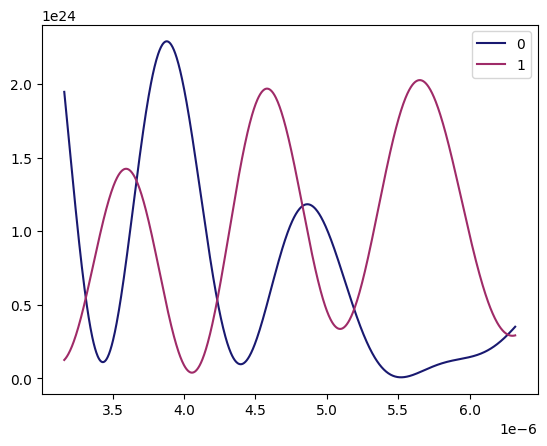

In [6]:
zzz = np.linspace(5*w, 10*w, 1000)
z2  = (1 + (zzz**2))
z_plot_0 = np.array(list(GeometricPotencial_3D_reducido(0*w,0,zzz,p,w,0)), dtype=float)
z_plot_1 = np.array(list(GeometricPotencial_3D_reducido(0*w,0,zzz,p,w,1)), dtype=float)

fig, ax = plt.subplots()
ax.plot(zzz, z_plot_0, label="0", color="#191970")
ax.plot(zzz, z_plot_1, label="1", color="#9F2B68")
ax.legend()
#plt.xlim([1530,1570])
#plt.ylim([-40,1])
plt.show()

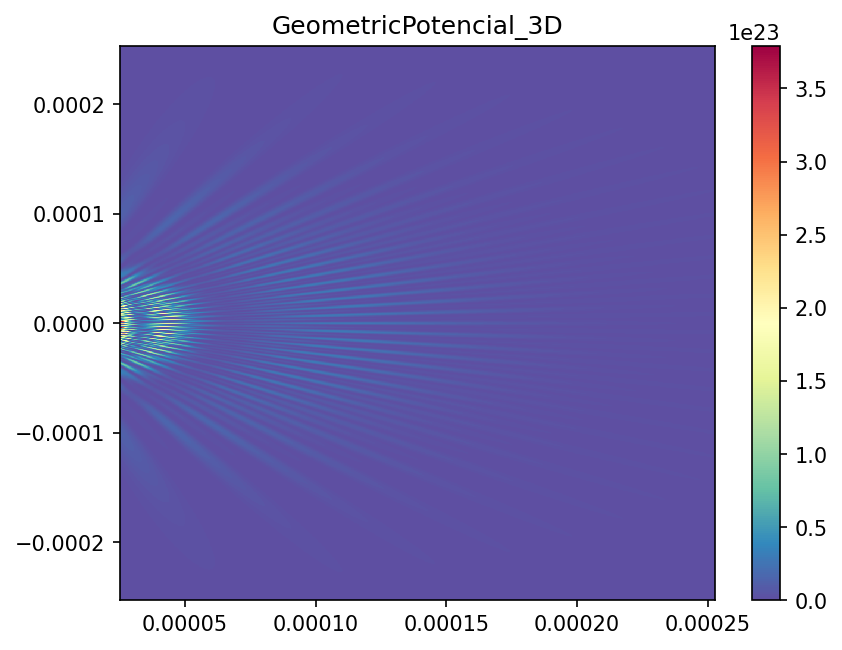

CPU times: user 6.24 s, sys: 1.09 s, total: 7.33 s
Wall time: 7.06 s


In [7]:
%%time
xx,zzz = np.meshgrid(np.linspace(-400*w, 400*w, 1000), np.linspace(40*w, 400*w, 1000))
zz = np.array(list(GeometricPotencial_3D_reducido(xx,0,zzz,p,w,1)), dtype=float)
#zz = zz[:-1, :-1]
z_min, z_max = zz.min()/1, zz.max()/1

#zz = zz / z_max

fig, ax = plt.subplots(dpi=150)
c = ax.pcolormesh(zzz, xx, zz, cmap='Spectral_r',  vmin = zz.min(), vmax = zz.max())
fig.colorbar(c, ax = ax)
ax.set_title('GeometricPotencial_3D')
#plt.savefig("Confinamiento")
plt.show()

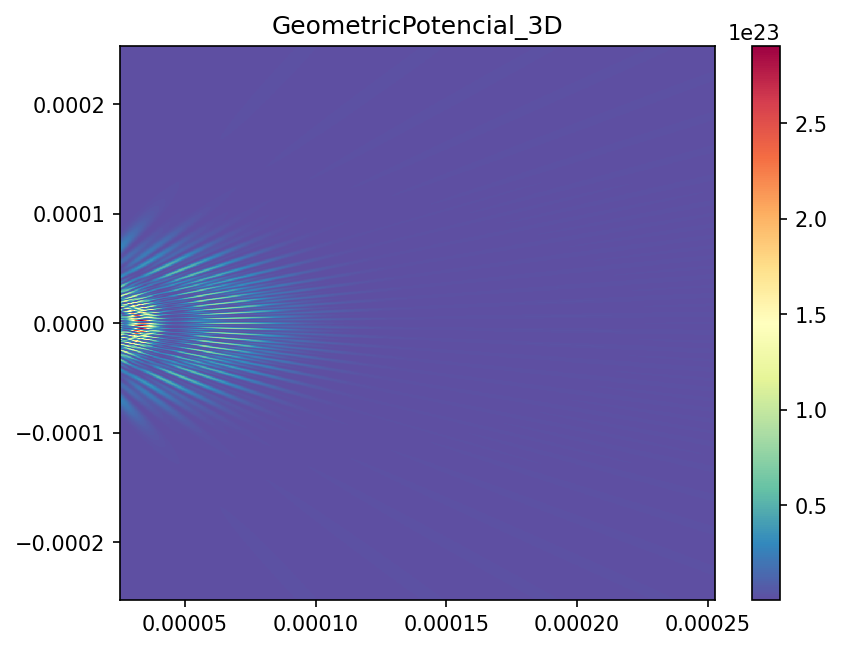

CPU times: user 5.38 s, sys: 287 ms, total: 5.67 s
Wall time: 5.4 s


In [8]:
%%time
xx,zzz = np.meshgrid(np.linspace(-400*w, 400*w, 1000), np.linspace(40*w, 400*w, 1000))
zz = np.array(list(GeometricPotencial_3D_reducido(xx,0,zzz,p,w,0)), dtype=float)
#zz = zz[:-1, :-1]
#z_min, z_max = zz.min()/1, zz.max()/1

#zz = zz / z_max

fig, ax = plt.subplots(dpi=150)
c = ax.pcolormesh(zzz, xx, zz, cmap='Spectral_r',  vmin = zz.min(), vmax = zz.max())
fig.colorbar(c, ax = ax)
ax.set_title('GeometricPotencial_3D')
#plt.savefig("Confinamiento")
plt.show()

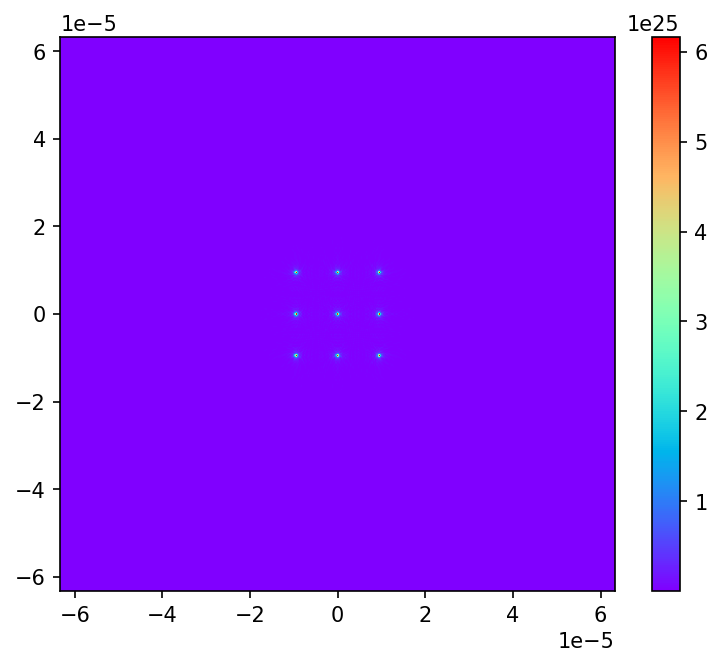

CPU times: user 6.79 s, sys: 280 ms, total: 7.07 s
Wall time: 6.8 s


(2.5912e-07, 1.896e-05)

In [9]:
%%time
square = np.linspace(-100*w, 100*w, 1000)
dz = .410*w
phase = 0
xx,yy = np.meshgrid(square, square)
zz = np.array(list(GeometricPotencial_3D_reducido(xx,yy,dz,p,w,phase)), dtype=float)
#zz = zz[:-1, :-1]
z_min, z_max = zz.min()/1, zz.max()/1

fig, (ax) = plt.subplots(dpi=150, subplot_kw={'aspect': 'equal'})
c = ax.pcolormesh(xx, yy, zz, cmap='rainbow',  vmin = z_min, vmax = z_max)
fig.colorbar(c, ax = ax)
plt.savefig("Geometric Potencial_coherence")
plt.show()
dz, 30*w

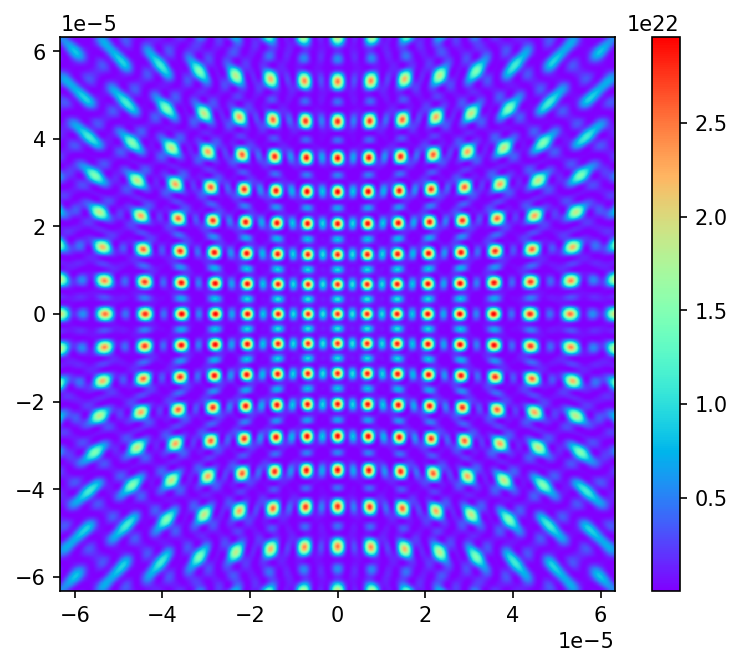

CPU times: user 7.06 s, sys: 275 ms, total: 7.33 s
Wall time: 7.06 s


0.0001

In [10]:
%%time
square = np.linspace(-100*w, 100*w, 1000)
dz = 0.0001
#dz = 7000*w
phase = 1
xx,yy = np.meshgrid(square, square)
zz = np.array(list(GeometricPotencial_3D_reducido(xx,yy,dz,p,w,1)), dtype=float)
#zz = zz[:-1, :-1]
z_mi, z_ma = zz.min()/1, zz.max()/1

fig, (ax) = plt.subplots(dpi=150, subplot_kw={'aspect': 'equal'})
c = ax.pcolormesh(xx, yy, zz, cmap='rainbow',  vmin = z_mi, vmax = z_ma)
fig.colorbar(c, ax = ax)
plt.savefig("Geometric Potencial_coherence")
plt.show()
dz

Al estar a distancias cortas, la periodicidad de los maximos repetitivos del patrón es similar a la periodicidad de los 

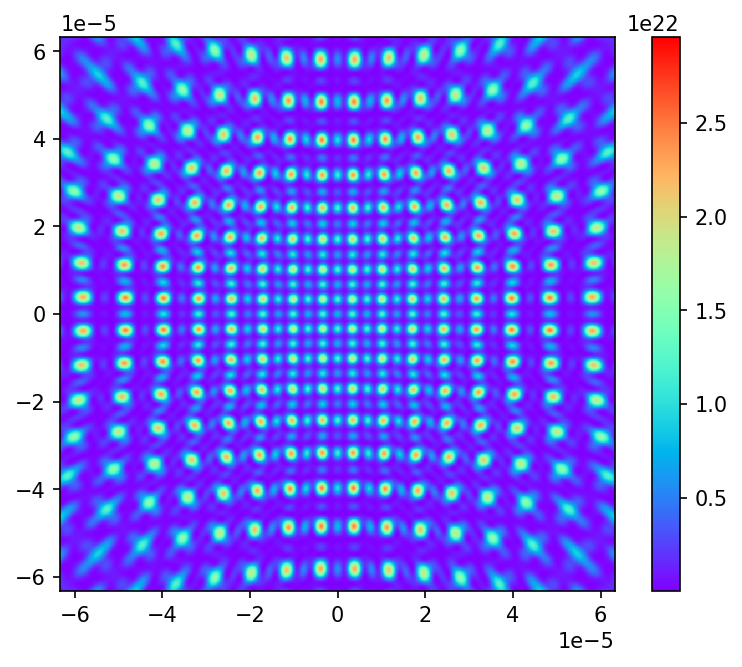

CPU times: user 7.34 s, sys: 281 ms, total: 7.62 s
Wall time: 7.35 s


0.0001

In [11]:
%%time
square = np.linspace(-100*w, 100*w, 1000)
dz = 0.0001
#dz = 7000*w
phase = 1
xx,yy = np.meshgrid(square, square)
zz = np.array(list(GeometricPotencial_3D_reducido(xx,yy,dz,p,w,0)), dtype=float)
#zz = zz[:-1, :-1]
#z_min, z_max = zz.min()/1, zz.max()/1

fig, (ax) = plt.subplots(dpi=150, subplot_kw={'aspect': 'equal'})
c = ax.pcolormesh(xx, yy, zz, cmap='rainbow',  vmin = z_mi, vmax = z_ma)
fig.colorbar(c, ax = ax)
plt.savefig("Geometric Potencial_coherence")
plt.show()
dz

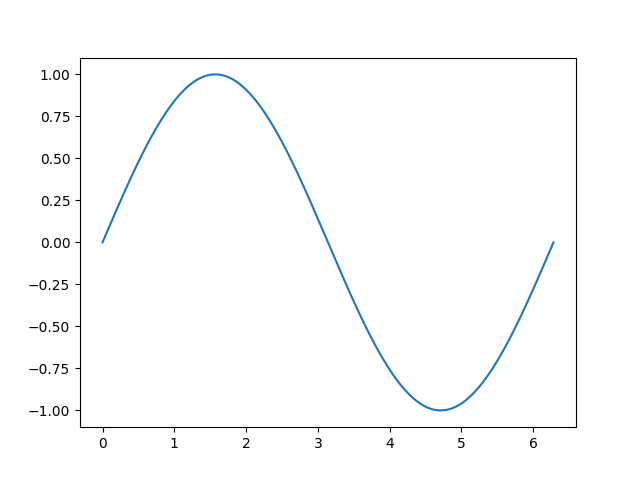

In [12]:
%matplotlib widget
from matplotlib.animation import FuncAnimation

# Generar datos
x = np.linspace(0, 2*np.pi, 200)
y = np.sin(x)

# Crear figura y ejes
fig, ax = plt.subplots()

# Crear línea inicial
line, = ax.plot(x, y)

# Función de animación
def update(frame):
    # Actualizar datos
    y = np.sin(x + frame/10)
    # Actualizar línea
    line.set_ydata(y)
    return [line]

# Crear animación
ani = FuncAnimation(fig, update, frames=100, blit=True)

# Mostrar animación
plt.show()

In [13]:
42

42